# SPE Acceptance #

This notebook runs most of the code needed to do SPE acceptance studies. It starts by making runlists that are used to group the different types of SPE runs together. These runlists are used to download the rawdata if it is unavailable on midway, and then submit midway jobs to process the raw data in way needed for this study. After the jobs finish (~6 hours), the data is read in and plotted in various ways. 

See the python modules in this repository for more details, especially spe_acceptance.py and analyze.py

In [1]:
import matplotlib
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt
import analyze
from channel_dict import channel_dict
import numpy as np
from matplotlib import cm
import os
import pymongo 
import re
from tqdm import tqdm
from pax.configuration import load_configuration
import hax
from hax.pmt_plot import plot_on_pmt_arrays, pmt_data
import pandas as pd

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#### Make runlists for any new runs that have been taken ####

In [2]:
from make_runlist_new import write_spe_lists
# dry run
write_spe_lists(write=False)

cursor has 963 runs
Number of runs and most recent run of each type
blank 24 14732
bottom 24 14733
topbulk 24 14734
topring 24 14735
14732 14733 14734 14735
14554 14555 14556 14557
14368 14369 14370 14371


In [3]:
# if happy with dry run, write the files
wrote = write_spe_lists(write=True)
print("We wrote these files:")
for f in wrote:
    print('\t' + f)

Number of runs and most recent run of each type
blank 24 14732
bottom 24 14733
topbulk 24 14734
topring 24 14735
We wrote these files:
	./runlists/runlist_14733_14734_14735.txt
	./runlists/runlist_14555_14556_14557.txt
	./runlists/runlist_14369_14370_14371.txt


In [4]:
with open("tmp_submit_file.txt", "w") as f:
    for file in wrote:
        f.write("%s\n" % file)

In [ ]:
%%bash

./notebook_submit.sh


#### Check if jobs still running ####

In [ ]:
from subprocess import Popen, PIPE
import time

def jobs_running():
    output = Popen(["squeue","--user", os.environ['USER']], stdin=PIPE, stdout=PIPE, stderr=PIPE).stdout.read()
    output = output.decode("utf-8").split("\n")
    jobs = len([l for l in output if 'spe' in l])
    return (jobs > 0)

# wait for jobs to finish
print("waiting for jobs to finish")
while jobs_running():
    print("..", end='')
    time.sleep(60)
print("\nDONE")

# Use the same runlist files to read in the data #

In [2]:
uri = 'mongodb://eb:%s@xenon1t-daq.lngs.infn.it:27017,copslx50.fysik.su.se:27017,zenigata.uchicago.edu:270\
17/run'
uri = uri % os.environ.get('MONGO_PASSWORD')
c = pymongo.MongoClient(uri,
                        replicaSet='runs',
                        readPreference='secondaryPreferred')
db = c['run']
collection = db['runs_new']

# get runlist files so that we know which runs go together
def get_runlist_files(dir, exclude = []):
    runlist_files = ['%s/%s' % (dir, f) for f in os.listdir(dir) if f.startswith("runlist") and f not in exclude and f.endswith(".txt")]
    return runlist_files

# find a regular run from which to extract self trigger thresholds
def find_regular_run(LED_run):
    query = {'source.type' : {'$ne' : 'LED'},
             '$and' : [{'number' : {'$lt': LED_run+20}}, 
                       {'number' : {'$gt' : LED_run-20}}
                      ]
            }
    cursor = collection.find(query, {'number' : True,
                                     'reader' : True,
                                     '_id' : False})
    
    
    
    runs = np.array([run['number'] for run in cursor 
                     if any([ r['register'] == '8060' 
                             for r in run['reader']['ini']['registers']])])
    
    if LED_run < 5144: #when thresholds changed
        runs = runs[runs<5144]
    elif LED_run > 5144:
        runs = runs[runs>5144]
    diff = abs(runs - LED_run)
    
    closest_run = runs[np.argmin(diff)]
    
    return closest_run
        
    
def get_threshold_changes():
    cursor = collection.find(
        {
            "tags.name": "_sciencerun0", 
            #"source.type": "AmBe",
            #"data": {"$elemMatch": {"type": "processed", "pax_version": "v6.4.2", "host": "midway-login1"}}
        }).sort("number", 1)


    # Loop
    st_list = []

    st_changes = []
    for doc in cursor:

        # Record self-trigger thresholds
        checklist = []
        for register in doc['reader']['ini']['registers']:
            if register['register'][-2:] == '60':
                checklist.append(register)
        sortedcheck = sorted(checklist, key=lambda k: k['register'])

        if sortedcheck != st_list:
            #print("Registers changed run " + str(doc['number']))
            st_changes.append(doc['number'])
            st_list = sortedcheck
    return st_changes

In [3]:
runlist_files = get_runlist_files('/home/awalsh272/SPE/runlists',
                                  exclude = ['runlist_6169_6170_6171.txt',
                                             'runlist_4511_4512_4513.txt',
                                             'runlist_4688_4689_4690.txt',
                                             'runlist_6446_6447_6448.txt',
                                             'runlist_12587_12588_12589.txt',
                                             'runlist_13128_13129_13130.txt',
                                             'runlist_14192_14193_14195.txt'])

Threshold run: 11434
Low acceptance pmts:  [2, 73, 137, 139, 190]


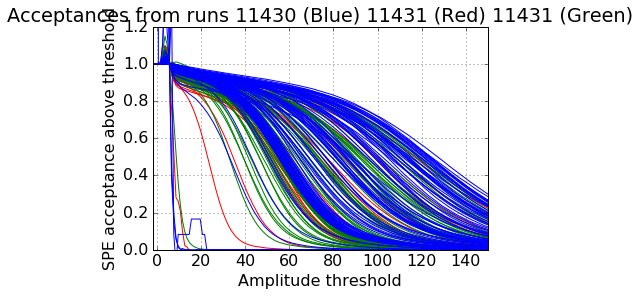

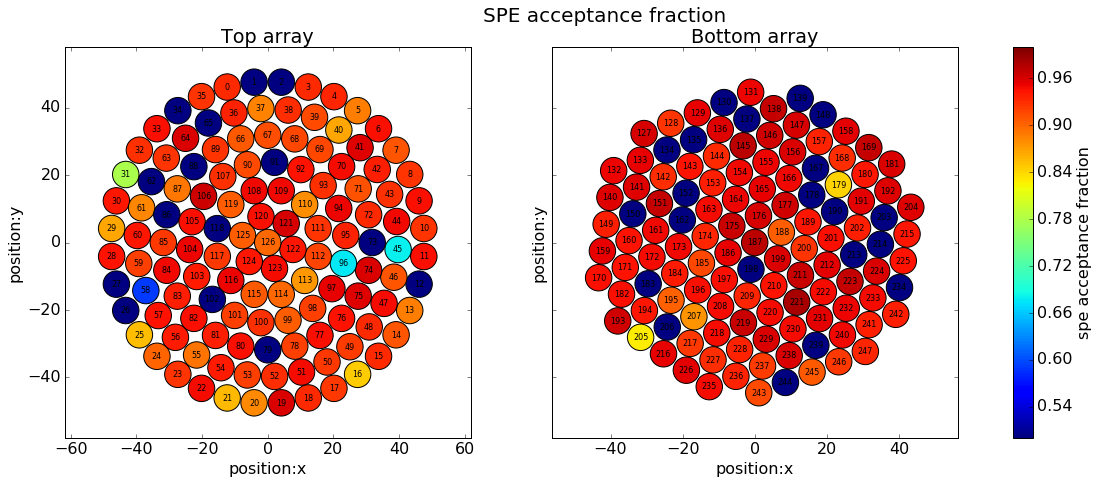

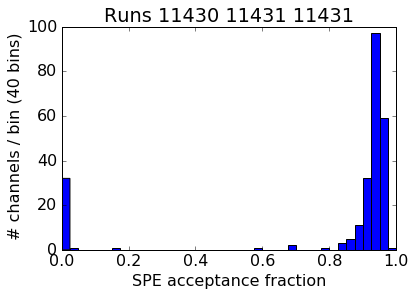

Threshold run: 11541


In [ ]:
means = []
medians = []
stds = []
bot_runs = []

n_bins = 40

acc_array = np.ones((len(runlist_files), len(channel_dict['all_channels'])))

for file, runlist in enumerate(sorted(runlist_files)):
    runlist = runlist.split('/')[-1].split('_')
    bottom_run = int(runlist[2])
    topbulk_run = int(runlist[3][:-4])
    topring_run = int(runlist[3][:-4])
    
    csv_file = "./acceptance_data/acceptances_%d_%d_%d.csv" % (bottom_run, topbulk_run, topring_run)
    
    if os.path.exists(csv_file):
        continue
    
    threshold_run = find_regular_run(bottom_run)
    print("Threshold run: %d" % threshold_run)
    try:
        thresholds = analyze.get_thresholds(threshold_run)
    except KeyError:
        thresholds = analyze.get_thresholds(threshold_run + 1)
    
    acceptances = analyze.get_acceptances_3runs(bottom_run, topring_run, 
                                                topbulk_run, thresholds, plot=True)
    
    
    acc_array[file, :] *= acceptances
    

    with open(csv_file, "w") as f:
        f.write("channel,acceptance\n")
        for ch, acc in enumerate(acceptances):
            f.write("%d,%0.4f\n" % (ch, acc))
        
    on_accs = acceptances
    on_accs = np.delete(on_accs, analyze.excluded_pmts)
    
    means.append(np.mean(on_accs))
    medians.append(np.median(on_accs))
    stds.append(np.std(on_accs))
    bot_runs.append(bottom_run)
    plt.figure()
    acc_hist, bins, patches = plt.hist(acceptances, bins = n_bins, range = (0,1))
    plt.title("Runs %d %d %d" % (bottom_run, topbulk_run, topring_run))
    plt.xlabel("SPE acceptance fraction")
    plt.ylabel(" # channels / bin (%d bins)" % n_bins)
    plt.show()
    plt.savefig("/project/lgrandi/xenon1t/spe_acceptance/plots/hist_%d-%d-%d.png" % 
                (bottom_run, topbulk_run, topring_run))
    
print('DONE')


12512 bad


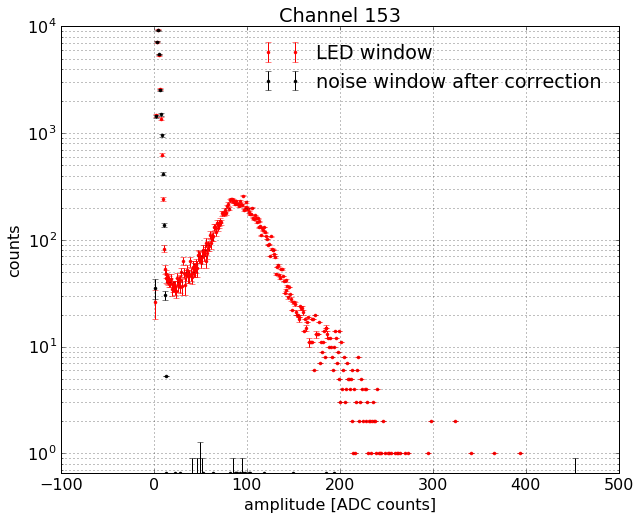

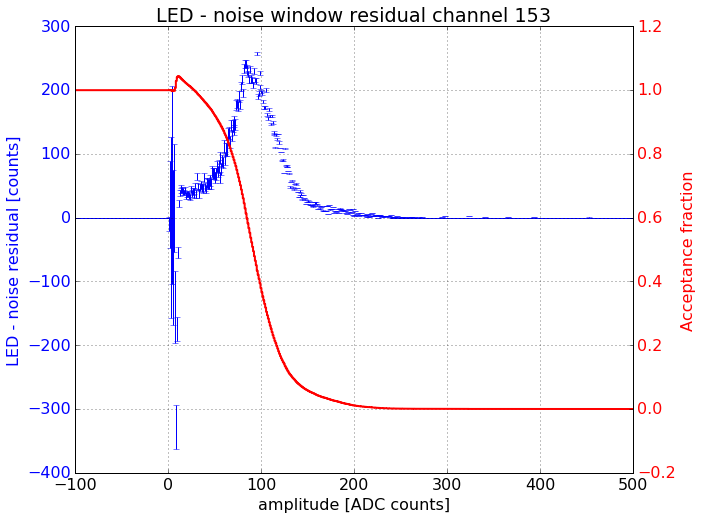

14089 bad


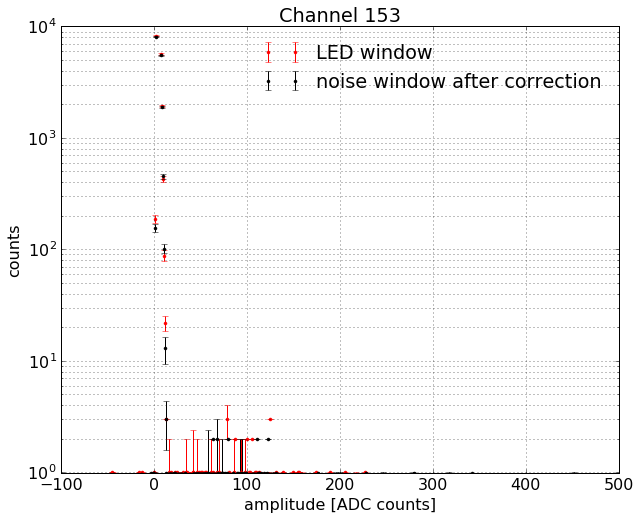

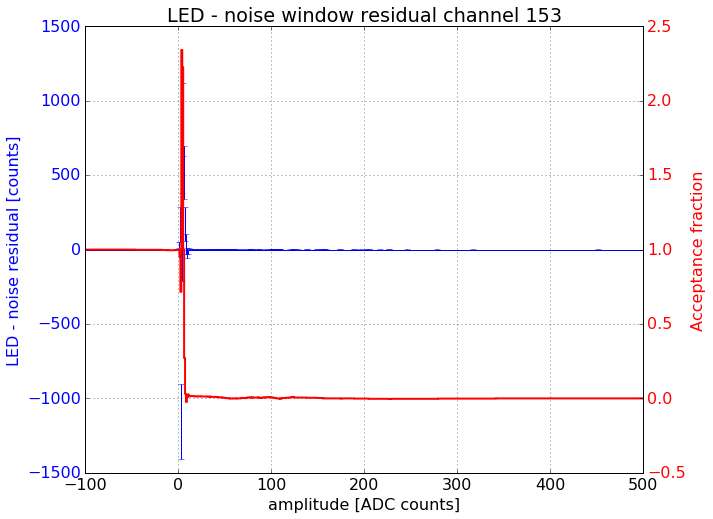

12213 good


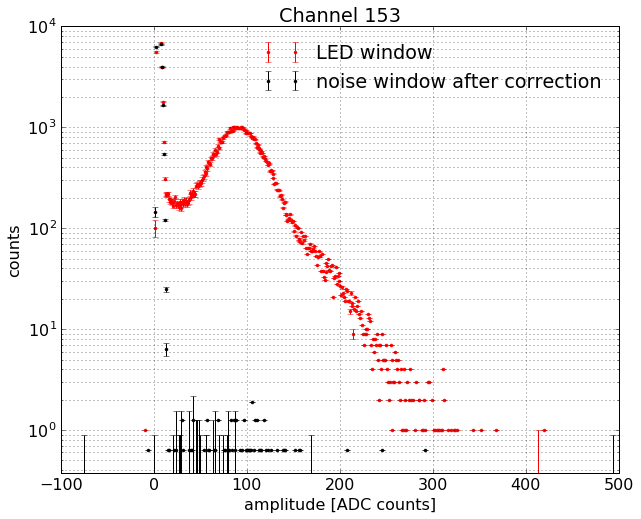

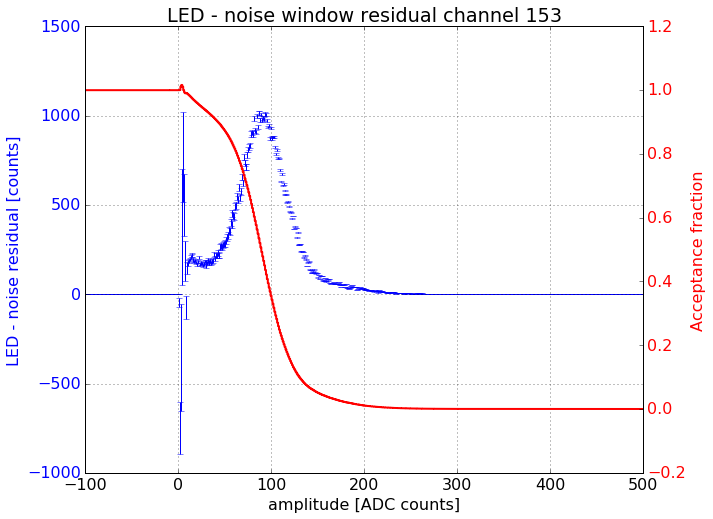

13434 bad


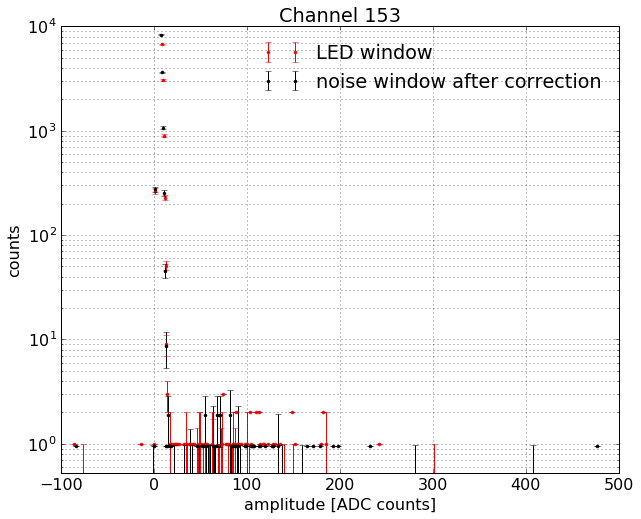

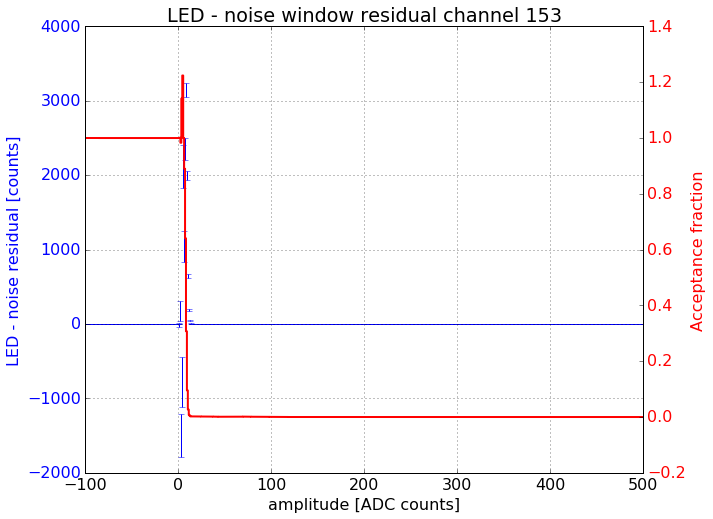

12769 bad


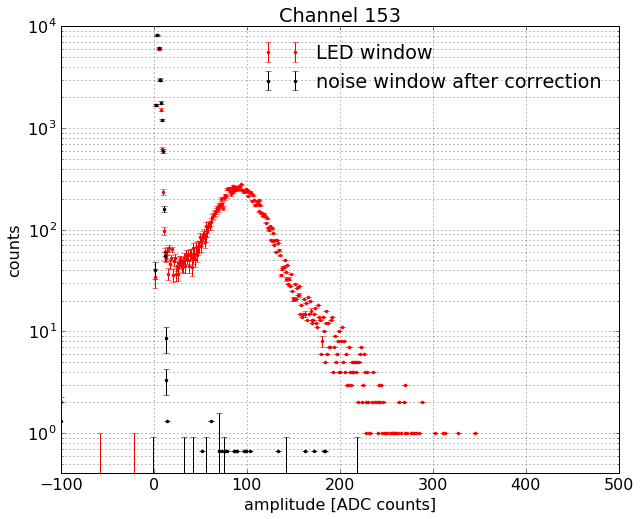

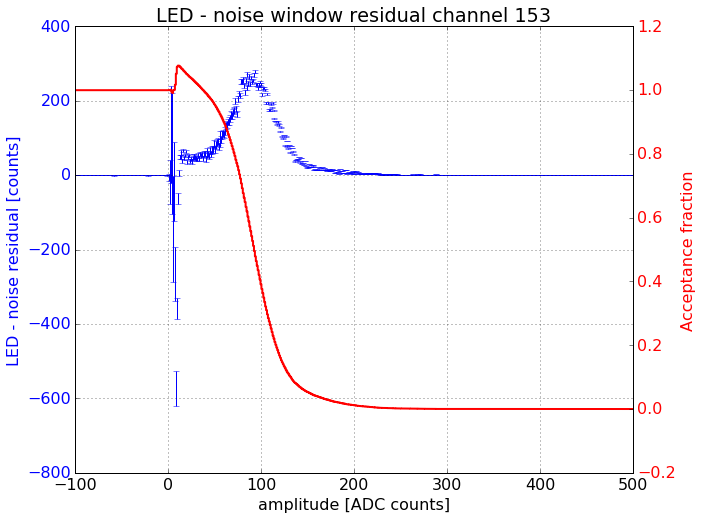

In [31]:
#plot spectra of bad runs
#all bottom runs

print(12512, "bad")
analyze.plot_channel(153, 12512, xlims=(-100,500), ylims = (-100, 10000), filedir = '')

print(14089, "bad")
analyze.plot_channel(153, 14089, xlims=(-100,500), ylims = (-100, 10000), filedir = '')

print(12213, "good")
analyze.plot_channel(153, 12213, xlims=(-100,500), ylims = (-100, 10000), filedir = '')

print(13434, "bad")
analyze.plot_channel(153, 13434, xlims=(-100,500), ylims = (-100, 10000), filedir = '')

print(12769, "bad")
analyze.plot_channel(153, 12769, xlims=(-100,500), ylims = (-100, 10000), filedir = '')

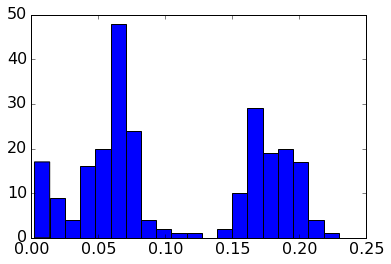

138
[6753, 6754, 6755, 6834, 6835, 6836, 6909, 6910, 6911, 6938, 6939, 6940, 6957, 6958, 6959, 6984, 6985, 6986, 7067, 7068, 7069, 7268, 7269, 7270, 7350, 7351, 7352, 7447, 7448, 7449, 7485, 7486, 7487, 7569, 7570, 7571, 7646, 7647, 7648, 7680, 7681, 7682, 7758, 7759, 7760, 7795, 7796, 7797, 7912, 7913, 7914, 7968, 7969, 7970, 8069, 8070, 8071, 8154, 8155, 8156, 8267, 8268, 8269, 8350, 8351, 8352, 8448, 8449, 8450, 8735, 8736, 8737, 8840, 8841, 8842, 8921, 8922, 8923, 9033, 9034, 9036, 9112, 9113, 9114, 9549, 9550, 9551, 9604, 9605, 9606, 9697, 9698, 9699, 9797, 9797, 9798, 9798, 9799, 9799, 10064, 10065, 10066, 11430, 11431, 11536, 11537, 11626, 11627, 11734, 11736, 11814, 11815, 12047, 12048, 12131, 12132, 12213, 12214, 12319, 12320, 12399, 12400, 12512, 12513, 12769, 12770, 12947, 12948, 13301, 13303, 13434, 13435, 13658, 13659, 13838, 13839, 14089, 14090]
[11429, 11430, 11431, 11535, 11536, 11537, 11625, 11626, 11627, 11733, 11734, 11736, 11813, 11814, 11815, 12046, 12047, 12048, 1

In [49]:
#plot all occupancies as a function of run number
def get_occ(c):
    return -1*np.log(c)

run_numbers=[]

all_run_numbers=[]

bottom_runs=[]
topb_runs=[]
topring_runs=[]

start_run = 6731
end_run = 1e6


datadir = 'acceptance_data'
acceptance_dict = {}

#adjusted for higher occs
for file in os.listdir(datadir):
    runs=file.split('_')
    bottom_run = int(runs[1])
    topb_run=int(runs[2])
    topring_run=int(runs[3].split('.')[0])
    if topb_run!=topring_run:
        if topring_run<11000:
            if not (start_run < bottom_run < end_run):
                continue 
            bottom_runs.append(bottom_run)
            topb_runs.append(topb_run)
            topring_runs.append(topring_run)
            all_run_numbers.append(bottom_run)
            all_run_numbers.append(topb_run)
            all_run_numbers.append(topring_run)
                                   
        else:
            continue
                                   
    else:
        bottom_runs.append(bottom_run)
        topb_runs.append(topb_run)
        topring_runs.append(topring_run)
        all_run_numbers.append(bottom_run)
        #all_run_numbers.append(topb_run)
        all_run_numbers.append(topring_run)
                                   
    #if topb_run==topring_run:
     #   all_run_numbers.append(bottom_run)
        #all_run_numbers.append(topb_run)
      #  all_run_numbers.append(topring_run)
    #else:
     #   all_run_numbers.append(bottom_run)
      #  all_run_numbers.append(topb_run)
       # all_run_numbers.append(topring_run)
    #data = pd.read_csv(file)
     
    
    data = pd.read_csv(datadir+'/'+file)
    
    acceptance_dict[bottom_run] = data['acceptance'].values 
    #acceptance_dict[all_runs] = data['acceptance'].values
    #acceptance_dict[topb_runs]=data['acceptance'].values
    #acceptance_dict[topring_runs]=data['acceptance'].values
#big_run_numbers.append(sorted(acceptance_dict.keys()))


for file, runlist in enumerate(sorted(runlist_files)):
    runlist = runlist.split('/')[-1].split('.')[0].split('_')[1:]
    for number in runlist:            
        run_numbers.append(number)
        
#for i in run_numbers:
 #   for r in all_run_numbers:
  #      if i==r:
   #         all_run_numbers.remove(i)
        
run_numbers = [int(r) for r in run_numbers]
all_run_numbers=sorted(all_run_numbers)



ch, corr = analyze.get_corrections(run_numbers[0])
plt.hist(get_occ(corr), bins=20)
plt.show()

print(len(all_run_numbers))
print(all_run_numbers)
print(run_numbers)


In [50]:
#all runs
corrections=np.ones((len(all_run_numbers), 248))
occs = np.ones_like(corrections)
data = {}

for i, run in enumerate(all_run_numbers):
    ch, corr=analyze.get_corrections(run)
    #corrections[i] = corr
    #occs[i] = get_occ(corr)
    data[run] = get_occ(corr)
    

In [51]:
df = pd.DataFrame(data)

bad_acc_runs=[12768, 12769, 12770 ,12130, 12131, 12132, 12211, 12213, 12214, 12398, 12399, 12400, 12511, 12512, 12513]
df.head()
#np.mean(df[11429])
#for run in bad_acc_runs:
 #   print(run)
  #  print(np.mean(df[run]))

#print(all_run_numbers)

#np.mean(df[14090])

,6753,6754,6755,6834,6835,6836,6909,6910,6911,6938,...,13301,13303,13434,13435,13658,13659,13838,13839,14089,14090
0,0.038230,0.113808,0.222339,0.041888,0.117414,0.227200,0.039912,0.109350,0.231116,0.047705,...,0.111820,0.228521,0.028858,0.026902,0.105177,0.218097,0.180154,0.251755,0.001503,-0.004075
1,-0.001883,0.002540,-0.001282,-0.001579,0.003873,-0.003419,0.001322,-0.001711,0.007939,0.002057,...,0.001009,0.009215,0.057649,0.068912,-0.011541,-0.009371,0.018397,-0.021073,0.005216,-0.003670
2,0.039420,0.114525,0.229967,0.049492,0.118330,0.230571,0.042547,0.114166,0.242231,0.043013,...,0.007163,0.011380,0.060137,0.056791,-0.005380,-0.000590,0.138379,0.061004,0.009498,-0.001233
3,0.035104,0.102958,0.204696,0.033153,0.103067,0.206763,0.040585,0.101000,0.221220,0.037439,...,0.102802,0.211028,0.020288,0.012689,0.100288,0.201691,0.252518,0.275920,0.002562,-0.000444
4,0.046024,0.121627,0.249526,0.054110,0.134967,0.245959,0.043791,0.115570,0.252471,0.049389,...,0.121830,0.259089,0.045158,0.053732,0.129808,0.255023,0.204264,0.282738,0.002873,-0.007063


In [8]:
#only new runs
new_corrections=np.ones((len(run_numbers), 248))
new_occs = np.ones_like(new_corrections)
new_data = {}

for i, run in enumerate(run_numbers):
    ch, corr=analyze.get_corrections(run)
    #corrections[i] = corr
    #occs[i] = get_occ(corr)
    new_data[run] = get_occ(corr)
    

FileNotFoundError: [Errno 2] No such file or directory: './data/run_14369/histograms.csv'

In [21]:
new_df=pd.DataFrame(new_data)

new_df.head()

#np.mean(new_df[14090])

,11429,11430,11431,11535,11536,11537,11625,11626,11627,11733,...,13435,13657,13658,13659,13837,13838,13839,14088,14089,14090
0,0.054448,0.116745,0.228952,0.042672,0.115940,0.237068,0.045880,0.114133,0.237343,0.046078,...,0.026902,0.036587,0.105177,0.218097,0.102751,0.180154,0.251755,0.000606,0.001503,-0.004075
1,0.004605,0.004305,0.002508,0.006578,-0.000269,-0.000098,-0.008645,0.001807,0.005823,-0.004596,...,0.068912,-0.010789,-0.011541,-0.009371,0.016166,0.018397,-0.021073,0.000169,0.005216,-0.003670
2,0.029518,0.016756,0.017402,0.011965,0.014585,0.031619,0.012552,0.017312,0.018222,0.033562,...,0.056791,-0.002636,-0.005380,-0.000590,0.132581,0.138379,0.061004,-0.000295,0.009498,-0.001233
3,0.045186,0.102179,0.206699,0.048073,0.103384,0.223368,0.047149,0.107968,0.219652,0.029725,...,0.012689,0.037682,0.100288,0.201691,0.196525,0.252518,0.275920,0.001144,0.002562,-0.000444
4,0.064627,0.120212,0.251831,0.045479,0.125906,0.269081,0.051250,0.123135,0.254260,0.048637,...,0.053732,0.050743,0.129808,0.255023,0.129230,0.204264,0.282738,0.003173,0.002873,-0.007063


In [52]:
#plots occs of all runs

bottom_occs = []

topb_occs=[]

topring_occs=[]

bottom_occs_all = []
topring_occs_all = []
topb_occs_all = []

bad_acc_runs=[12768, 12769, 12770 ,12130, 12131, 12132, 12211, 12213, 12214, 12398, 12399, 12400, 12511, 12512, 12513]

#shifted to higher occupancies
for r in df.columns:
    if r in topb_runs: #bottom_runs=topb_runs
        boccs = [o for ch, o in enumerate(df[r].values) if ch in channel_dict['bottom_channels']]
        bottom_occs.append(np.mean(boccs))
        #bottom_occs_all.append(np.mean(df[r].values))
        #tboccs= [o for ch, o in enumerate(df[r].values) if ch in channel_dict['top_bulk']]
        #topb_occs.append(np.mean(tboccs))
    
    elif r in topring_runs:
        #boccs = [o for ch, o in enumerate(df[r].values) if ch in channel_dict['bottom_channels']]
        #bottom_occs.append(np.mean(boccs))
        tboccs= [o for ch, o in enumerate(df[r].values) if ch in channel_dict['top_bulk']]
        topb_occs.append(np.mean(tboccs))
        #topb_occs_all.append(np.mean(df[r].values))
        troccs= [o for ch, o in enumerate(df[r].values) if ch in channel_dict['top_outer_ring']]
        topring_occs.append(np.mean(troccs))
        
    #elif r in topring_runs:
        #tboccs= [o for ch, o in enumerate(df[r].values) if ch in channel_dict['top_bulk']]
        #topb_occs.append(np.mean(tboccs))
        #topb_occs_all.append(np.mean(df[r].values))
        #boccs = [o for ch, o in enumerate(df[r].values) if ch in channel_dict['bottom_channels']]
        #bottom_occs.append(np.mean(boccs))
        #troccs= [o for ch, o in enumerate(df[r].values) if ch in channel_dict['top_outer_ring']]
        #topring_occs.append(np.mean(troccs))
print(len(bottom_runs), len(bottom_occs), len(topb_runs), len(topb_occs), len(topring_runs), len(topring_occs))
print(sorted(bottom_runs))
print(sorted(topb_runs))
print(sorted(topring_runs))
fig = plt.figure()
ax1 = fig.add_subplot(111)      
ax1.scatter(bottom_runs, bottom_occs, color='r', label='Bottom Runs')
ax1.scatter(topb_runs, topb_occs, color='g', label='Topbulk Runs')
ax1.scatter(topring_runs, topring_occs, color='b', label='Topring Runs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("Run Number")
plt.ylabel("Average Occupancy[Avg PE/Trigger]")
plt.title("Average Occupancy vs Run Number", fontsize=17)
#plt.ylim(0.1, 0.25)
plt.show()


52 51 52 33 52 33
[6753, 6834, 6909, 6938, 6957, 6984, 7067, 7268, 7350, 7447, 7485, 7569, 7646, 7680, 7758, 7795, 7912, 7968, 8069, 8154, 8267, 8350, 8448, 8735, 8840, 8921, 9033, 9112, 9549, 9604, 9697, 9797, 9797, 10064, 11430, 11536, 11626, 11734, 11814, 12047, 12131, 12213, 12319, 12399, 12512, 12769, 12947, 13301, 13434, 13658, 13838, 14089]
[6754, 6835, 6910, 6939, 6958, 6985, 7068, 7269, 7351, 7448, 7486, 7570, 7647, 7681, 7759, 7796, 7913, 7969, 8070, 8155, 8268, 8351, 8449, 8736, 8841, 8922, 9034, 9113, 9550, 9605, 9698, 9798, 9798, 10065, 11431, 11537, 11627, 11736, 11815, 12048, 12132, 12214, 12320, 12400, 12513, 12770, 12948, 13303, 13435, 13659, 13839, 14090]
[6755, 6836, 6911, 6940, 6959, 6986, 7069, 7270, 7352, 7449, 7487, 7571, 7648, 7682, 7760, 7797, 7914, 7970, 8071, 8156, 8269, 8352, 8450, 8737, 8842, 8923, 9036, 9114, 9551, 9606, 9699, 9799, 9799, 10066, 11431, 11537, 11627, 11736, 11815, 12048, 12132, 12214, 12320, 12400, 12513, 12770, 12948, 13303, 13435, 13659, 

ValueError: x and y must be the same size

In [22]:
#plots only new runs

new_bottom_occs = []
new_bottom_runs=[]

new_topb_occs=[]
new_topb_runs=[]

new_topring_occs=[]
new_topring_runs=[]

for file, runlist in enumerate(sorted(runlist_files)):
    runlist = runlist.split('/')[-1].split('_')
    bottom_run = int(runlist[1])
    topbulk_run = int(runlist[2])
    topring_run = int(runlist[3][:-4])
    new_bottom_runs.append(bottom_run)
    new_topb_runs.append(topbulk_run)
    new_topring_runs.append(topring_run)
    
for r in new_df.columns:
    if r in bottom_runs:
        boccs = [o for ch, o in enumerate(new_df[r].values) if ch in channel_dict['bottom_channels']]
        new_bottom_occs.append(np.mean(boccs))
    elif r in topb_runs:
        tboccs= [o for ch, o in enumerate(new_df[r].values) if ch in channel_dict['top_bulk']]
        new_topb_occs.append(np.mean(tboccs))       
    elif r in topring_runs:
        troccs= [o for ch, o in enumerate(new_df[r].values) if ch in channel_dict['top_outer_ring']]
        new_topring_occs.append(np.mean(troccs))

print(new_bottom_runs)
print(new_bottom_occs)
fig = plt.figure()
ax1 = fig.add_subplot(111)      
ax1.scatter(new_bottom_runs, new_bottom_occs, color='r', label='Bottom Runs')
ax1.scatter(new_topb_runs, new_topb_occs, color='g', label='Topbulk Runs')
ax1.scatter(new_topring_runs, new_topring_occs, color='b', label='Topring Runs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("Run Number")
plt.ylabel("Average Occupancy[Avg PE/Trigger]")
plt.title("Average Occupancy vs Run Number", fontsize=17)
#plt.ylim(0.1, 0.25)
plt.show()



NameError: name 'new_df' is not defined

In [118]:
#dont need to run this
#checking occs of bad acc runs
bad_acc_runs=[12768, 12769, 12770] #12130, 12131, 12132, 12211, 12213, 12214, 12398, 12399, 12400, 12511, 12512, 12513, 12768, 12769, 12770]
good_runs=[11429,11430,11431]

avg_occs=[]
good_occs=[]

for run in bad_acc_runs:
    ch=[]
    ch_occ={}
    if run in bottom_runs:
        ch=channel_dict["bottom_channels"]
    if run in topb_runs:
        ch=channel_dict["top_bulk"]
    if run in topring_runs:
        ch=channel_dict["top_outer_ring"]
    #print(run, "Bad Run Occs")
    for i in ch:
        ch_occ[i]=df[run][i]
        occs=ch_occ.values()
        #for r in range()
        #if df[run][i]-df[run]
        #if ch_occ[i]>0.3 or ch_occ[i]<0.05:
            #print (run, i, ch_occ[i])
    avg_occ=sum(occs)/len(occs)
    avg_occs.append(avg_occ)
    print(run, ch_occ, "average: "+str(avg_occs[-1]))

for run in good_runs:
    goodch=[]
    good_ch_occ={}
    if run in bottom_runs:
        ch=channel_dict["bottom_channels"]
    if run in topb_runs:
        ch=channel_dict["top_bulk"]
    if run in topring_runs:
        ch=channel_dict["top_outer_ring"]
    #print(run, "Bad Run Occs")
    for i in goodch:
        good_ch_occ[i]=df[run][i]
        occs=ch_occ.values()
        #for r in range()
        #if df[run][i]-df[run]
        #if ch_occ[i]>0.3 or ch_occ[i]<0.05:
            #print (run, i, ch_occ[i])
    avg_occ=sum(occs)/len(occs)
    avg_occs.append(avg_occ)
    #print(run, ch_occ, "average: "+str(avg_occs[-1]))


for i in range(min(len(avg_occs),len(good_occs))):
    if abs(avg_occs[i]-good_occs[i])>0.03:
        print ("Big difference: ", avg_occs[i], good_occs[i]) 
    else:
        print("occs are fine")
#print(ch_occ)

#print channel_dict["bottom_channels"]
#print ch

12768 {127: 0.052719524363268232, 128: 0.15541905503393239, 129: 0.15344529963810036, 130: 0.0055622010914463896, 131: 0.12289370786076695, 132: 0.1404094878577562, 133: 0.15446165742477375, 134: -0.016771372383136928, 135: -0.071169945159652692, 136: 0.13970714348863314, 137: -0.054438161184611422, 138: 0.1208636907304786, 139: -0.0040432341435863361, 140: 0.15516539063451626, 141: 0.14298520261342079, 142: 0.1409622407284031, 143: 0.1435734120885625, 144: 0.15971542845402037, 145: 0.18140082752467546, 146: 0.14248469921894738, 147: 0.14465648504592588, 148: -0.21508336662514058, 149: 0.1158010776851342, 150: -0.014798930416653741, 151: 0.15647712940946107, 152: -0.037315758931816788, 153: 0.1315150779589459, 154: 0.16301746208992773, 155: 0.17058342270108245, 156: 0.14891574358574061, 157: 0.13938973783899786, 158: 0.17028930623601077, 159: 0.12380429263596346, 160: 0.13209034612118833, 161: 0.12488229033298874, 162: -0.033564450992940906, 163: 0.13932700872392562, 164: 0.16339288444

# Plot SPE acceptance as function of time #

In [13]:
# read in data files

evo_data = pd.DataFrame(acceptance_dict)

#bad_bot_runs=[13837, 13433, 14088]
#for i in bad_bot_runs:
#    del evo_data[i]

evo_data.head()
    

,11430,11536,11626,11734,11814,12047,12131,12213,12319,12399,12512,12769,12947,13301,13434,13658,13838,14089
0,0.9330,0.9420,0.9191,0.9083,0.9722,0.9275,0.8923,0.9650,0.9443,0.8893,1.0150,1.1117,0.9755,0.9421,-0.0008,0.9616,0.8496,0.0242
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0047,0.0010,0.0054,-0.0005,-0.0041,0.0008,0.0009,0.0051,0.0077,0.0014,-0.0007,0.0000,0.0008,0.0000,0.0000,0.0000,0.0001,0.0000
3,0.9335,0.9226,0.8984,0.9635,0.9287,0.9067,0.8869,0.9475,0.9275,0.8563,0.9640,1.0200,0.9401,0.9175,0.0021,0.9313,0.7224,-3.2591
4,0.9340,0.9225,0.9501,0.9771,0.9463,0.9034,0.8267,0.9345,0.9586,0.8032,0.9902,1.0215,0.9777,0.9390,-0.0002,0.9237,0.8498,0.0034


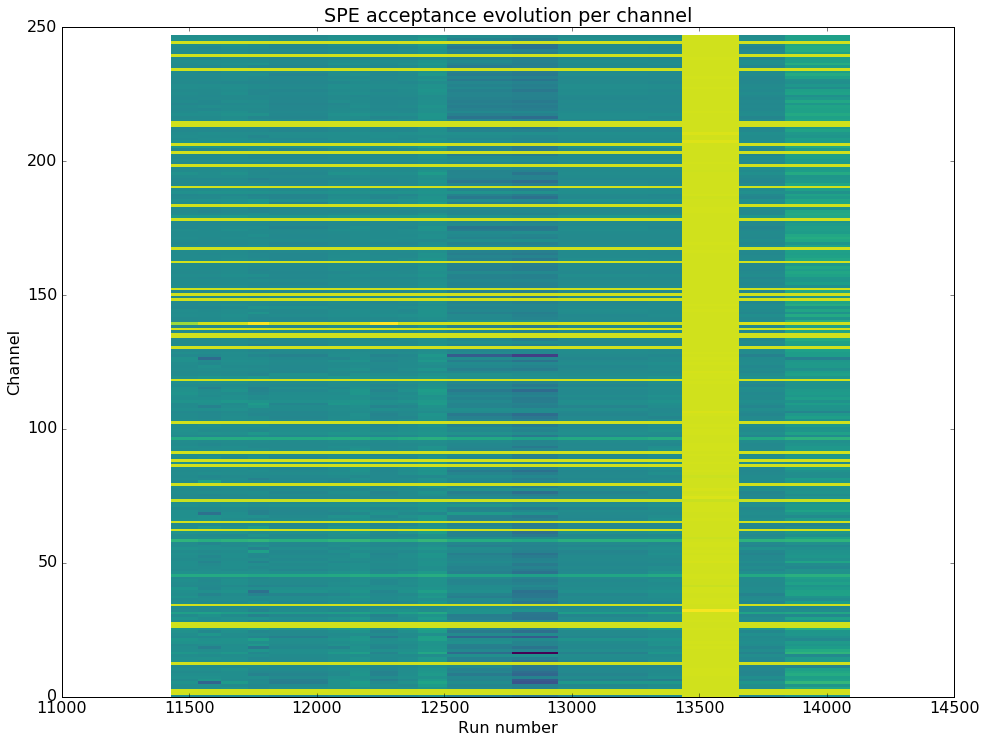

In [14]:
xx, yy = np.meshgrid(evo_data.columns, evo_data.index)

plt.figure(figsize=(16,12))
plt.pcolor(xx, yy, evo_data.values, cmap='viridis_r')
plt.title("SPE acceptance evolution per channel")
plt.xlabel("Run number")
plt.ylabel("Channel")
plt.show()

In [15]:
# can now look at acceptace for individual run

from matplotlib.ticker import AutoMinorLocator
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter, drange, AutoDateFormatter, AutoDateLocator
from datetime import datetime

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

def plot_channel_evo(channel, dataframe, vlines=None):
    plt.figure(figsize=(10, 6))
    #times = [get_run_time(run) for run in dataframe.columns]
    plt.scatter(dataframe.columns, dataframe.loc[[channel]])
    plt.title('Channel %d' % channel)
    plt.ylabel('SPE acceptance fraction')
    plt.xlabel('Run number')
    plt.ylim(-0.05, 1.1)
    ax = plt.gca()
    ax.yaxis.grid(True) #(b=True, which='major', color='0.65',linestyle='-')
#    ax.xaxis.set_major_locator(MonthLocator())
#    ax.xaxis.set_minor_locator(DayLocator())
#    locator = AutoDateLocator()
#    ax.xaxis.set_major_formatter(DateFormatter("%b '%y"))
    if vlines is not None:
        n_regions = len(vlines) + 1
        regions = []
        for line in vlines:
            regions.append(r for r in dataframe.columns if r < line)
            print(np.mean(dataframe[regions].loc[[channel]]))
#            plt.axvline(get_run_time(line))
            plt.axvline(line)

## plot average acceptance vs run number ##

In [16]:
# ignore off channels (acceptance < 0.05)

def custom_mean(df):
    new_means = []
    for col in sorted(df):
        new_vals = [val for val in df[col] if val > 0.05]
        new_means.append(np.mean(new_vals))
    d = {}
    for i, mean in enumerate(new_means):
        d[df.columns[i]] = mean
    return pd.DataFrame(d, index=['mean'])

def custom_median(df):
    new_meds = []
    for col in sorted(df):
        new_vals = [val for val in df[col] if val > 0.05]
        new_meds.append(np.median(new_vals))
    d = {}
    for i, med in enumerate(new_meds):
        d[df.columns[i]] = med
    return pd.DataFrame(d, index=['median'])
    

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


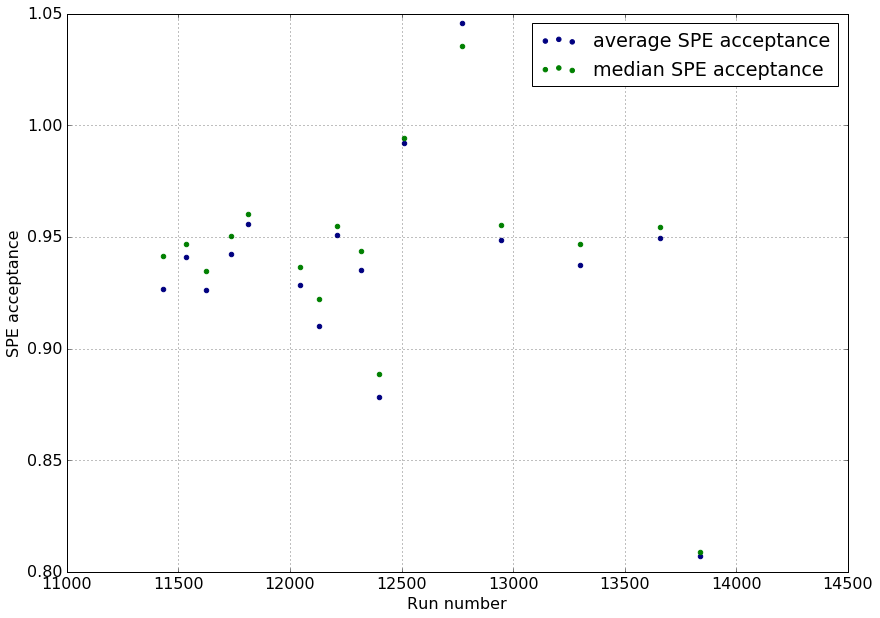

In [17]:
plt.figure(figsize=(14,10))
plt.scatter(evo_data.columns, custom_mean(evo_data).values, label = 'average SPE acceptance', color='navy')
plt.scatter(evo_data.columns, custom_median(evo_data).values, label = 'median SPE acceptance', color='green')
plt.ylabel('SPE acceptance')
plt.xlabel('Run number')
plt.grid()
plt.legend(loc='upper right')
plt.ylim(0.8, 1.05)
plt.savefig('acceptance_evolution.png')
plt.show()

## Runs where we saw changes in low acceptance pmts ## 

In [114]:
# retrieve low acceptance pmts

low_acc_dict = {}

for col in evo_data:
    low_acc_dict[col] = [ch for ch, a in enumerate(evo_data[col]) if a < 0.5]

In [115]:
low_acc_pmts = []
for run, l in low_acc_dict.items():
    low_acc_pmts = list(set(low_acc_pmts).union(set(l)))
    
print(sorted(low_acc_pmts))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [116]:
last_list = 'init'
changes = {}
for key in sorted(low_acc_dict):
    this_list = sorted(low_acc_dict[key])
    if last_list == 'init':
        last_list = this_list
        
    if this_list != last_list:
        changed_pmts = set(last_list).symmetric_difference(set(this_list))
        changes[key] = changed_pmts
        
    last_list = this_list

In [117]:
s = "Runs where we saw changes in low acceptance PMTS, and the PMTS that changed"
print(s)
print("-" * len(s))

for run in sorted(changes):
    print(run, changes[run])

Runs where we saw changes in low acceptance PMTS, and the PMTS that changed
---------------------------------------------------------------------------
6909 {48, 49, 51, 96}
7912 {2}
12398 {58}
12511 {58}
13433 {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 136, 138, 140, 141, 142, 143, 144, 145, 146, 147, 149, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 204, 205, 207

In [112]:
# plot the evolution of the pmts that changed:
pmts_that_changed = []
for run in changes:
    for ch in changes[run]:
        pmts_that_changed.append(ch)

for ch in pmts_that_changed:
    plot_channel_evo(ch, evo_data)
    plt.show()

NameError: name 'changes' is not defined

In [ ]:
plot_channel_evo(137, evo_data)
plt.show()